In [38]:
import pandas as pd
import numpy as np
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [39]:
cwd = os.getcwd()
if os.path.basename(cwd) == "Notebooks":
    project_root = os.path.dirname(cwd)
else:
    project_root = cwd
data_path1 = os.path.join(project_root, "data", "listings.csv")
data_path2 = os.path.join(project_root, "data", "reviews.csv")
df1 = pd.read_csv(data_path1)
df2 = pd.read_csv(data_path2)

In [40]:
# collect all 'comments' from same 'listing_id' in df2 and then merge with df1 on 'id'
df2_grouped = df2.groupby('listing_id')['comments'].apply(lambda x: ': '.join(x.dropna())).reset_index()
df = pd.merge(df1, df2_grouped, left_on='id', right_on='listing_id', how='left')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22684 entries, 0 to 22683
Data columns (total 81 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            22684 non-null  int64  
 1   listing_url                                   22684 non-null  object 
 2   scrape_id                                     22684 non-null  int64  
 3   last_scraped                                  22684 non-null  object 
 4   source                                        22684 non-null  object 
 5   name                                          22684 non-null  object 
 6   description                                   22070 non-null  object 
 7   neighborhood_overview                         8225 non-null   object 
 8   picture_url                                   22684 non-null  object 
 9   host_id                                       22684 non-null 

In [42]:
# remove the following features: listing_url, scrape_id, last_scraped, source, picture_url, host_url, host_thumbnail_url, host_picture_url, host_neighbourhood, host_has_profile_pic, neighbourhood, neighbourhood_group_cleansed, bathrooms, beds, minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm, calendar_updated, calendar_last_scraped, number_of_reviews_l30d, license, listing_id, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms
df = df.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_has_profile_pic', 'neighbourhood', 'neighbourhood_group_cleansed', 'bathrooms', 'beds', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'calendar_last_scraped', 'number_of_reviews_l30d', 'license', 'listing_id', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'neighborhood_overview', 'host_about'])  
df = df.dropna(subset=['comments', 'price']).reset_index(drop=True)

In [43]:
# remove '$' from the price feature
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
# remove listings with price > 99999 and minimum_nights > 365
df = df[(df['price'] <= 99999) & (df['minimum_nights'] <= 365)].reset_index(drop=True)

In [44]:
# plot of Airbnb listings in CPH (5000 random samples)
nyc_center = [55.6761, 12.5683]
m = folium.Map(location=nyc_center, zoom_start=11, tiles='cartodbpositron')
for _, row in df.sample(5000, random_state=1).iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=1,
        color="red",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)
m

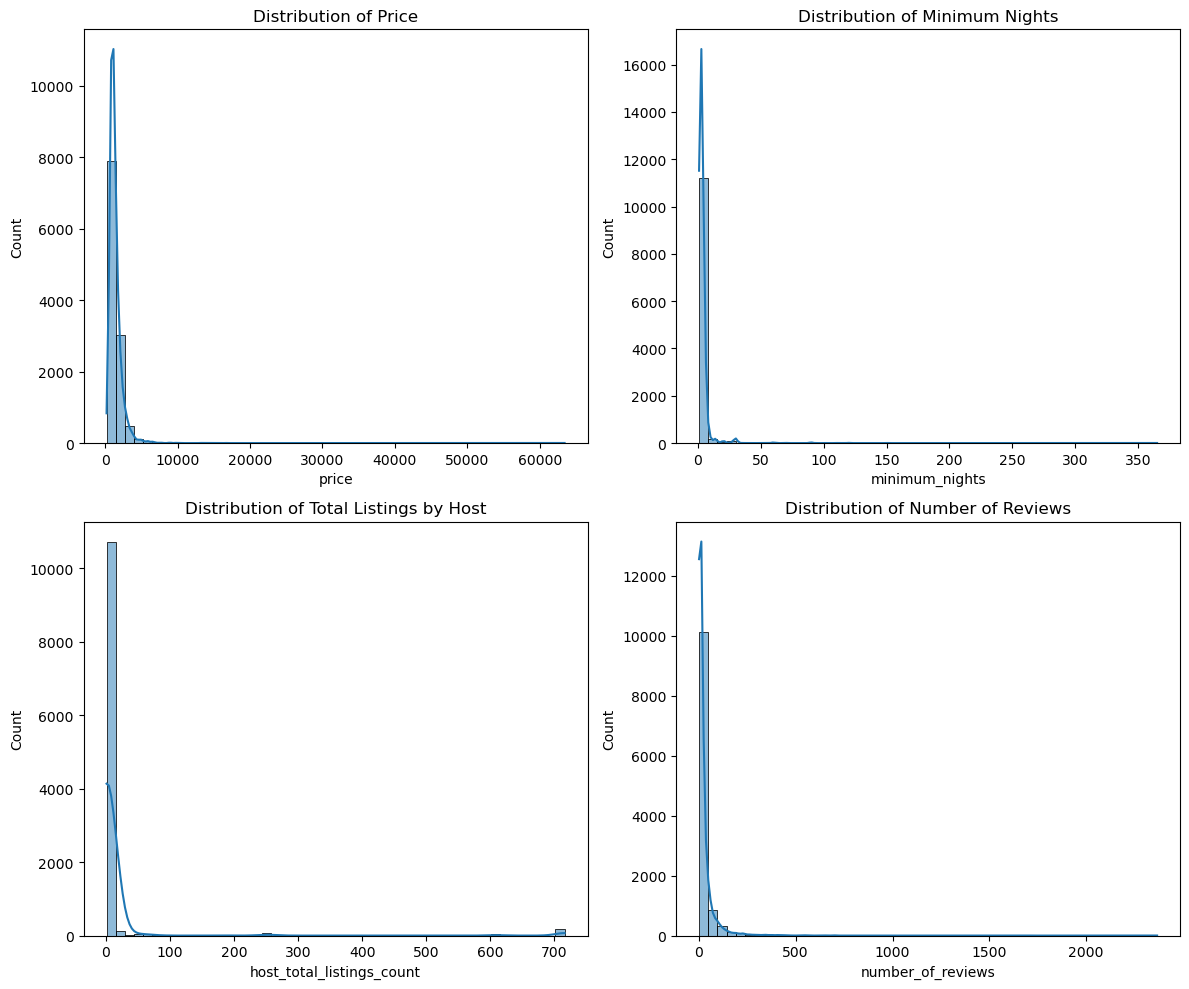

In [45]:
# distribution for price and minimum nights
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(df['price'], bins=50, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of Price')
sns.histplot(df['minimum_nights'], bins=50, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribution of Minimum Nights')
sns.histplot(df['host_total_listings_count'], bins=50, ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Distribution of Total Listings by Host')
sns.histplot(df['number_of_reviews'], bins=50, ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Distribution of Number of Reviews')
plt.tight_layout()
plt.show()

In [46]:
raadhus_lat, raadhus_lon = 55.6759, 12.5681
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return c * r

df["dist_to_raadhus_km"] = haversine(df["latitude"], df["longitude"], raadhus_lat, raadhus_lon)

In [47]:
# cwd = os.getcwd()
# if os.path.basename(cwd) == "Notebooks":
#     project_root = os.path.dirname(cwd)
# else:
#     project_root = cwd
# save_path = os.path.join(project_root, "data", "Airbnb_DK_Processed_Data.csv")
# df.to_csv(save_path, index=False)